# DATA PREPARATION


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = 'wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [4]:
!wget $data 

--2024-10-13 16:23:54--  http://wget/
Resolving wget (wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address 'wget'
--2024-10-13 16:23:54--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: 'laptops.csv.1'

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.05s   

2024-10-13 16:23:54 (5.72 MB/s) - 'laptops.csv.1' saved [298573/298573]

FINISHED --2024-10-13 16:23:54--
Total wall clock time: 0.5s
Downloaded: 1 files, 292K in 0.05s (5.72 MB/s)


In [5]:
df = pd.read_csv('laptops.csv')

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
base = ['ram','storage','screen','final_price']

In [8]:
df = df[base]

# EXPLORATORY DATA ANALYSIS

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:xlabel='final_price', ylabel='Count'>

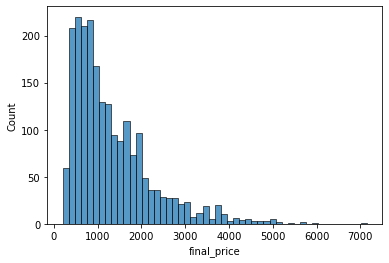

In [10]:
sns.histplot(df.final_price, bins=50)

In [11]:
price_logs = np.log1p(df.final_price)

<AxesSubplot:xlabel='final_price', ylabel='Count'>

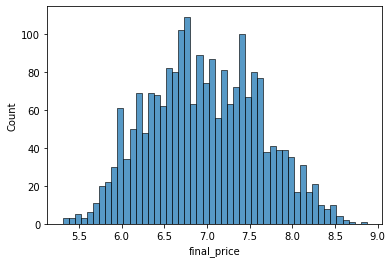

In [12]:
sns.histplot(price_logs, bins=50)

### Data has a long tail

In [13]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [14]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [15]:
df.info

<bound method DataFrame.info of       ram  storage  screen  final_price
0       8      512    15.6      1009.00
1       8      256    15.6       299.00
2       8      256    15.6       789.00
3      16     1000    15.6      1199.00
4      16      512    15.6       669.01
...   ...      ...     ...          ...
2155   16     1000    17.3      2699.99
2156   16     1000    17.3      2899.99
2157   32     1000    17.3      3399.99
2158   16     1000    13.4      1899.99
2159   16      256    13.4      1699.99

[2160 rows x 4 columns]>

In [16]:
df['ram'].median()

16.0

# SETTING UP THE VALIDATION FRAMEWORK

In [17]:
n = len(df)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n-n_val-n_test

In [18]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [19]:
n_val, n_test, n_train

(432, 432, 1296)

In [20]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [21]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [22]:
y_train = df_train['final_price']
y_val = df_val['final_price']
y_test = df_test['final_price']

In [23]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

# LINEAR REGRESSION W/O REGULARIZATION

## Linear Regression Code

In [24]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

## RMSE

In [31]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# define a function that prepares a training dataset using a certain fill method.
def prepare_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X= df.values
    return X

### Using fillna=0

In [34]:
#prepare the proper training dataset
X_train = prepare_X(df_train, fillna_value=0)
#fit the linear regression model
w0, w = train_linear_regression(X_train, y_train)

#prepare validation dataset
X_val = prepare_X(df_val,fillna_value=0)
#obtain the predicted data
y_pred = w0 + X_val.dot(w)
#Important, test the predicted data AGAINST y_val
round(rmse(y_val, y_pred),2)

597.36

### Using fillna=mean

In [35]:
mean = df_train.screen.mean()
#prepare the proper training dataset
X_train = prepare_X(df_train, fillna_value=mean)
#fit the linear regression model
w0, w = train_linear_regression(X_train, y_train)

#prepare validation dataset
X_val = prepare_X(df_val,fillna_value=mean)
#obtain the predicted data
y_pred = w0 + X_val.dot(w)
#Important, test the predicted data AGAINST y_val
round(rmse(y_val, y_pred),2)

600.27

# REGULARIZED LINEAR REGRESSION

In [118]:
base = ['ram','storage','screen']
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [119]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [120]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

597.3616819856043

### TUNING THE MODEL

In [128]:
for r in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, round(score,2))

0.0 676.8954853021177 597.36
0.01 676.273681722254 597.36
0.1 670.7284836330148 597.35
1 619.9030834122343 597.21
5 463.77716971501684 597.01
10 352.79713367721575 597.06
100 66.92071440182079 597.9


# HOW DOES THE SEED AFFECT THE MODEL?

In [121]:
def seed_split(n):
    df = pd.read_csv('laptops.csv')
    df = df.fillna(0)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    idx = np.arange(len(df))
    
    np.random.seed(n)
    np.random.shuffle(idx)


    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    
    y_train = df_train['final_price']
    y_val = df_val['final_price']
    y_test = df_test['final_price']
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    return rmse(y_val, y_pred)

In [122]:
seed_split(1)

636.7985423056692

In [123]:
seeds_rmse = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    seeds_rmse.append([i,seed_split(i)])

In [124]:
seeds_rmse

[[0, 565.4520868770974],
 [1, 636.7985423056692],
 [2, 588.9558697908009],
 [3, 597.8148920012577],
 [4, 571.9627915111049],
 [5, 573.2383256618972],
 [6, 647.3438328407462],
 [7, 550.439818448574],
 [8, 587.3335036169905],
 [9, 576.1017929433037]]

In [125]:
seeds_rmse = pd.DataFrame(seeds_rmse, columns=['rand_seed', 'rmse'])

In [126]:
round(np.std(seeds_rmse['rmse']),3)

29.176

# USING THE MODEL

In [144]:
n = len(df)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n-n_val-n_test

In [145]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

In [146]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [147]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [148]:
y_train = df_train['final_price']
y_val = df_val['final_price']
y_test = df_test['final_price']

In [149]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [150]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
df_full_train = df_full_train.fillna(0)
X_full_train = prepare_X(df_full_train)

In [151]:
y_full_train = np.concatenate([y_train, y_val])
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [152]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

608.6099822049691